# Basic imports

In [27]:
%reload_ext autoreload
%autoreload 2

import uproot
import polars as pl
import numpy as np
from tqdm import tqdm
import awkward as ak
import matplotlib.pyplot as plt
import pandas as pd
import os
from systs import SystConfig, CAFManager, Systematic, MultiPlot, VariationManager, SystAnalyzer, Flavor, create_oscillation_yaml_from_systematics
plt.rcParams.update({'font.size': 18})
%config InlineBackend.figure_format = "retina"

# Loading all the relevant data, variations and dials definitions

In [ ]:
# /exp/dune/data/users/pgranger/caf_new_sum.2.6M_weighted.root
# /exp/dune/data/users/pgranger/genie_extracted_new_cafs2.root
cafs = CAFManager("/Users/pgranger/test-ff/atmospherics-tools/fast-osc-feedback/caf_new_sum.2.6M_weighted.root", "genie_extracted_new_cafs2.root")
systs = SystConfig("systs_atmospherics_v1.fcl")
# /exp/dune/data/users/pgranger/merged_new_systs_wmec_fixed.root
variation_manager = VariationManager("./merged_new_systs_wmec.root")
analyzer = SystAnalyzer(cafs, systs, variation_manager)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/awkward/_nplikes/array_module.py:515: RuntimeWarning: invalid value encountered in cast
  return self._module.concatenate(arrays, axis=axis, casting="same_kind")
100%|██████████| 23/23 [00:01<00:00, 15.09it/s]


# A plot to show that the MEC decay angle affects direction reconstruction

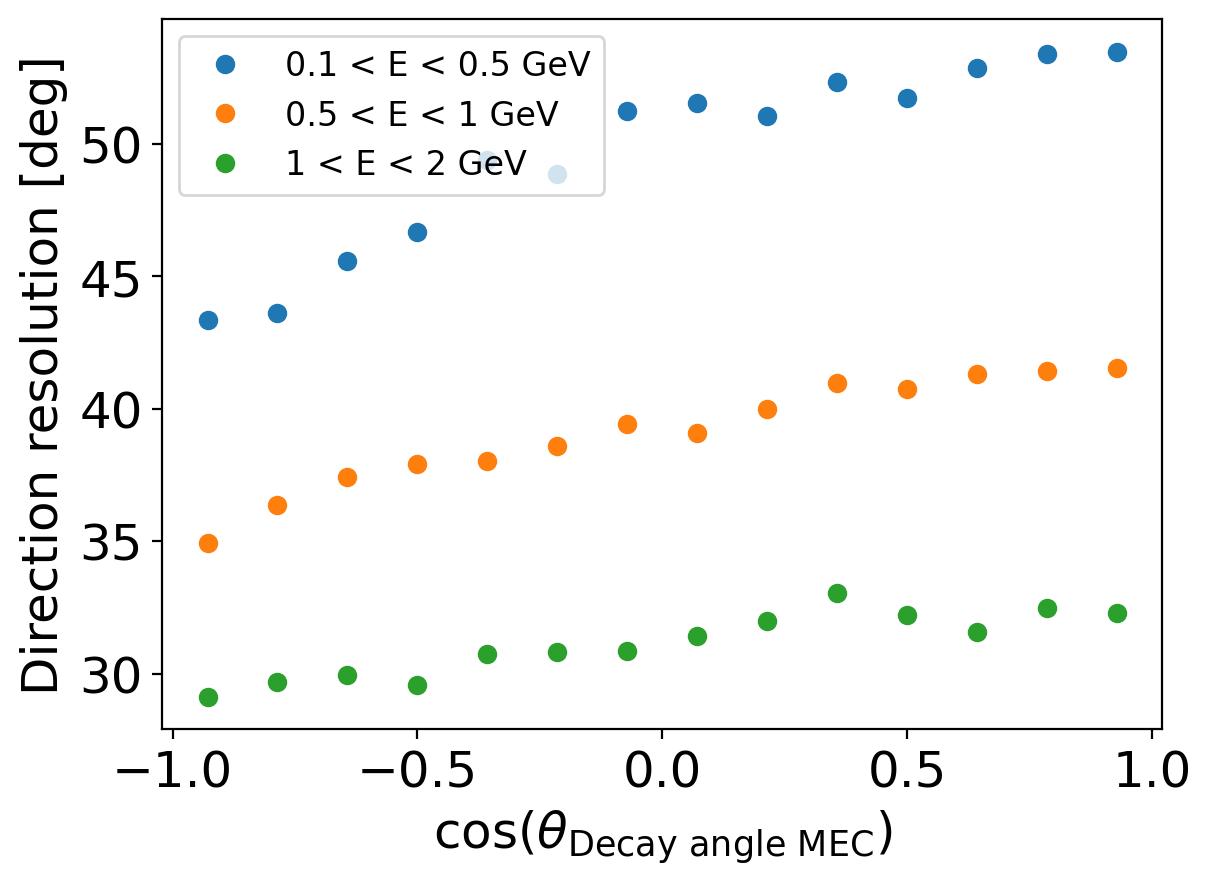

In [ ]:
# 

from scipy.stats import binned_statistic

mec = cafs.data.filter(pl.col('DecayAngMEC') >= -1, pl.col('reco_direc').abs() < 1).with_columns(
    direc_res = (pl.col('direc_true').arccos() - pl.col('reco_direc').arccos()) * 180/np.pi,
    Eres = pl.col('reco_E') - pl.col('nu_E')
)

angBins = np.linspace(-1, 1, 15)
angCenters = (angBins[1:] + angBins[:-1])/2

#Plotting the direction reco as a function of energy
# Ebins = np.linspace(0, 2, 40)


for Erange in ([0.1, 0.5], [0.5, 1], [1, 2]):
    selected = mec.filter(
        pl.col('nu_E') > Erange[0],
        pl.col('nu_E') < Erange[1]
    )
    std = binned_statistic(selected['DecayAngMEC'].cos(), selected['direc_res'], statistic='std', bins=angBins).statistic
    plt.errorbar(angCenters, std, fmt='o', label=f'{Erange[0]} < E < {Erange[1]} GeV')
plt.xlabel(r'$\cos(\theta_{\rm Decay\ angle\ MEC})$')
plt.ylabel('Direction resolution [deg]')
plt.legend(fontsize=12)
plt.tight_layout()

# Printing all the available systematics

In [31]:
systs

╔══════════════════════════════════════════════════════════╗
║           📊 Systematic Configuration                    ║
╚══════════════════════════════════════════════════════════╝

┌─ 🔧 Provider: GENIEReWeight_DUNE_v2
│  (54 systematics)
│
│  ├── ✓ AhtBY
│  ├── ✓ BhtBY
│  ├── ✓ CV1uBY
│  ├── ✓ CV2uBY
│  ├── ✓ EtaNCEL
│  ├── ✓ FrAbs_N
│  ├── ✓ FrAbs_pi
│  ├── ✓ FrCEx_N
│  ├── ✓ FrCEx_pi
│  ├── ✓ FrInel_N
│  ├── ✓ FrInel_pi
│  ├── ✓ FrPiProd_N
│  ├── ✓ FrPiProd_pi
│  ├── ✓ MFP_N
│  ├── ✓ MFP_pi
│  ├── ✓ MaCCRES
│  ├── ✓ MaNCEL
│  ├── ✓ MaNCRES
│  ├── ✓ MvCCRES
│  ├── ✓ MvNCRES
│  ├── ✓ NonRESBGvbarnCC1pi
│  ├── ✓ NonRESBGvbarnCC2pi
│  ├── ✓ NonRESBGvbarnNC1pi
│  ├── ✓ NonRESBGvbarnNC2pi
│  ├── ✓ NonRESBGvbarpCC1pi
│  ├── ✓ NonRESBGvbarpCC2pi
│  ├── ✓ NonRESBGvbarpNC1pi
│  ├── ✓ NonRESBGvbarpNC2pi
│  ├── ✓ NonRESBGvnCC1pi
│  ├── ✓ NonRESBGvnCC2pi
│  ├── ✓ NonRESBGvnNC1pi
│  ├── ✓ NonRESBGvnNC2pi
│  ├── ✓ NonRESBGvpCC1pi
│  ├── ✓ NonRESBGvpCC2pi
│  ├── ✓ NonRESBGvpNC1pi
│  ├── ✓ NonRESBGvpNC2pi
│  ├── ✓ RDecBR1eta
│  ├── ✓ RDecBR1gamma
│  ├── ✓ Theta_Delta2Npi
│  ├── ✓ VecFFCCQEshape
│  ├── ✓ ZExpA1CCQE
│  ├── ✓ ZExpA2CCQE
│  ├── ✓ ZExpA3CCQE
│  ├── ✓ ZExpA4CCQE
│  ├── ✓ DecayAng2MEC
│  ├── ✓ DecayAngMEC
│  ├── ✓ DecayAngMECVariationResponse
│  ├── ✓ EnergyDependence_CCMEC
│  ├── ✓ FracDelta_CCMEC
│  ├── ✓ FracPN_CCMEC
│  ├── ✓ XSecShape_CCMEC
│  ├── ✓ XSecShape_CCMEC_Empirical
│  ├── ✓ XSecShape_CCMEC_Martini
│  └── ✓ Fakedial
│
┌─ 🔧 Provider: zexpansion_weighter_toolconfig
│  (4 systematics)
│
│  ├── ✓ b1
│  ├── ✓ b2
│  ├── ✓ b3
│  └── ✓ b4
│
┌─ 🔧 Provider: MiscInteractionSysts_DUNE_TDR_FakeData
│  (4 systematics)
│
│  ├── ✓ C12ToAr40_2p2hScaling_nu
│  ├── ✓ C12ToAr40_2p2hScaling_nubar
│  ├── ✓ nuenuebar_xsec_ratio
│  └── ✓ nuenumu_xsec_ratio
│
┌─ 🔧 Provider: ResIso_ResonanceIsolation
│  (4 systematics)
│
│  ├── ✓ MaRes_ResCode0
│  ├── ✓ MaRes_ResCode1
│  ├── ✓ MvRes_ResCode0
│  └── ✓ MvRes_ResCode1
│
┌─ 🔧 Provider: WSRWEngine
│  (2 systematics)
│
│  ├── ✓ nucleus_radius
│  └── ✓ surface_thickness
│
────────────────────────────────────────────────────────────
📈 Summary: 5 providers, 68 total systematics

In [ ]:
# old_systs = systs = SystConfig("systs.fcl")
# yaml_str = systs.to_oscillation_yaml(
#         output_file='oscillation_all_systematics.yaml',
#         sample_names=["ND_*", "FD_*", "ATM"],
#         error=1.0,
#         mcmc_step_scale=0.4
#     )

YAML configuration saved to oscillation_all_systematics.yaml


# Defining some modes and filters

In [30]:
modes = ["CCQE",
  "CC1Kaon",
  "CCDIS",
  "CCRES",
  "CCCOH",
  "CCDiff",
  "CCNuEl",
  "CCIMD",
  "CCAnuGam",
  "CCMEC",
  "CCCOHEL",
  "CCIBD",
  "CCGlRES",
  "CCIMDAnn"
]


nue_filter = pl.col('reco_pdg') == Flavor.NuE
numu_filter = pl.col('reco_pdg') == Flavor.NuMu
ccqe_filter = pl.col('mode') == modes.index("CCQE")
ccres_filter = pl.col('mode') == modes.index("CCRES")

# Demonstrating some 2d plots

/Users/pgranger/cernbox/systematics/systs.py:775: RuntimeWarning: invalid value encountered in divide
  
/Users/pgranger/cernbox/systematics/systs.py:776: RuntimeWarning: invalid value encountered in divide
  # Remove x-tick labels from top plot


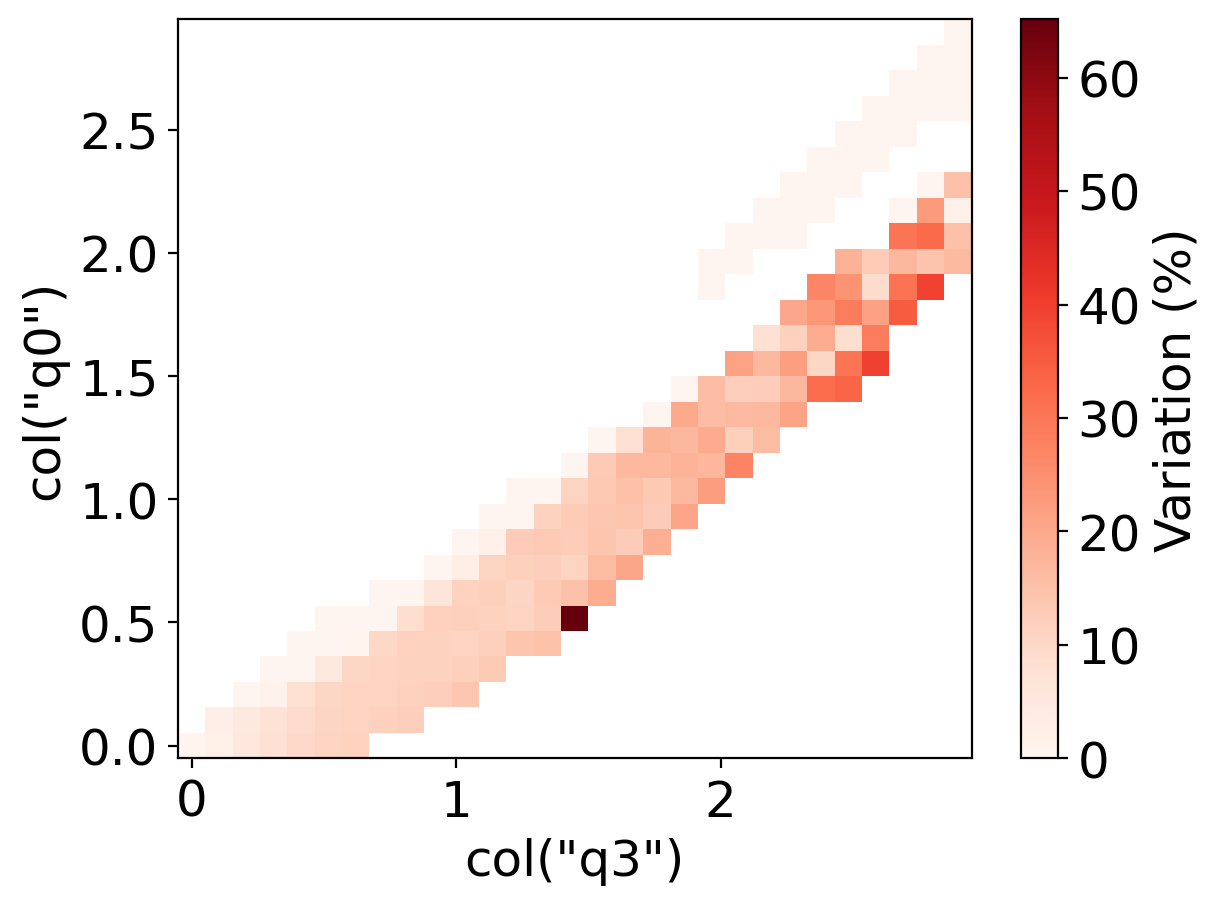

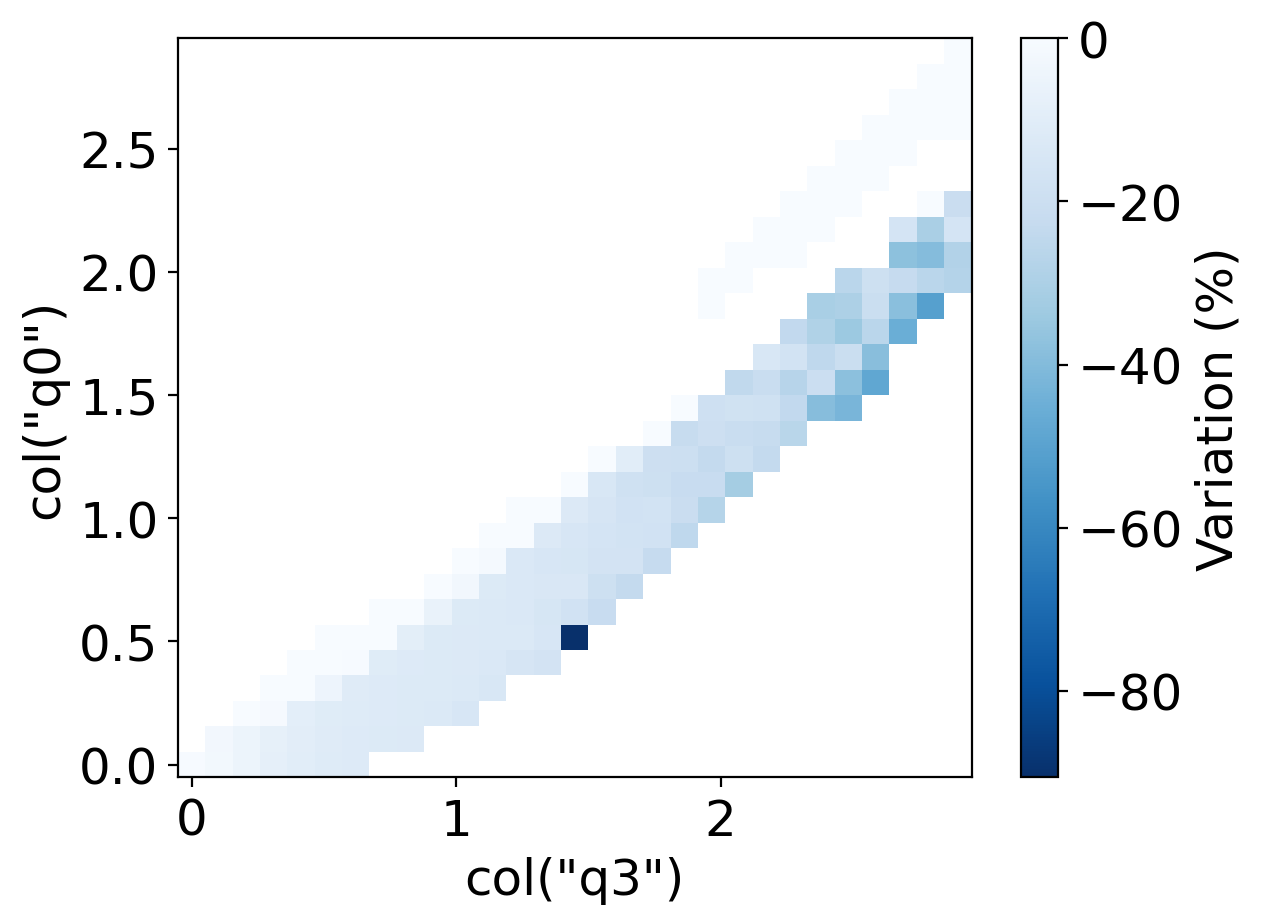

In [33]:
analyzer.plot_2d_fractional_variation(['b1', 'b2', 'b3','b4'], pl.col('q3'), np.linspace(0, 3, 30), pl.col('q0'), np.linspace(0, 3, 30), numu_filter & ccqe_filter)
analyzer.plot_2d_fractional_variation(['b1', 'b2', 'b3','b4'], pl.col('q3'), np.linspace(0, 3, 30), pl.col('q0'), np.linspace(0, 3, 30), numu_filter & ccqe_filter, which="down")
# analyzer.plot_2d_fractional_variation('E2p2h_A_nu', pl.col('q0'), np.linspace(0, 2, 30), pl.col('q3'), np.linspace(0, 2, 20), numu_filter, which="down")


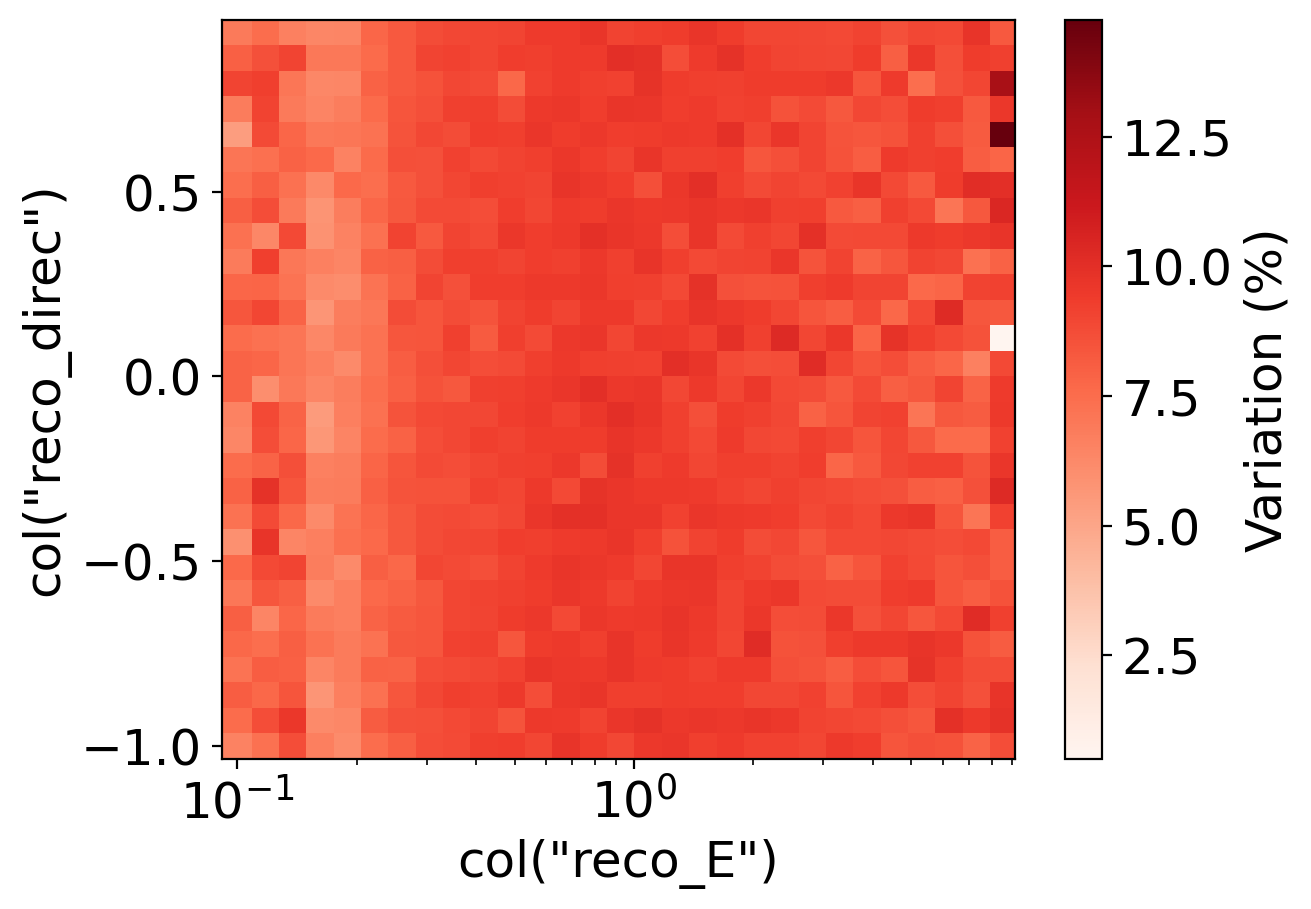

In [34]:
analyzer.plot_2d_fractional_variation(['b1', 'b2', 'b3','b4'], pl.col('reco_E'), np.logspace(-1, 1, 30), pl.col('reco_direc'), np.linspace(-1, 1, 30), numu_filter & ccqe_filter)
plt.xscale('log')


# Demonstrating 1d variation plot

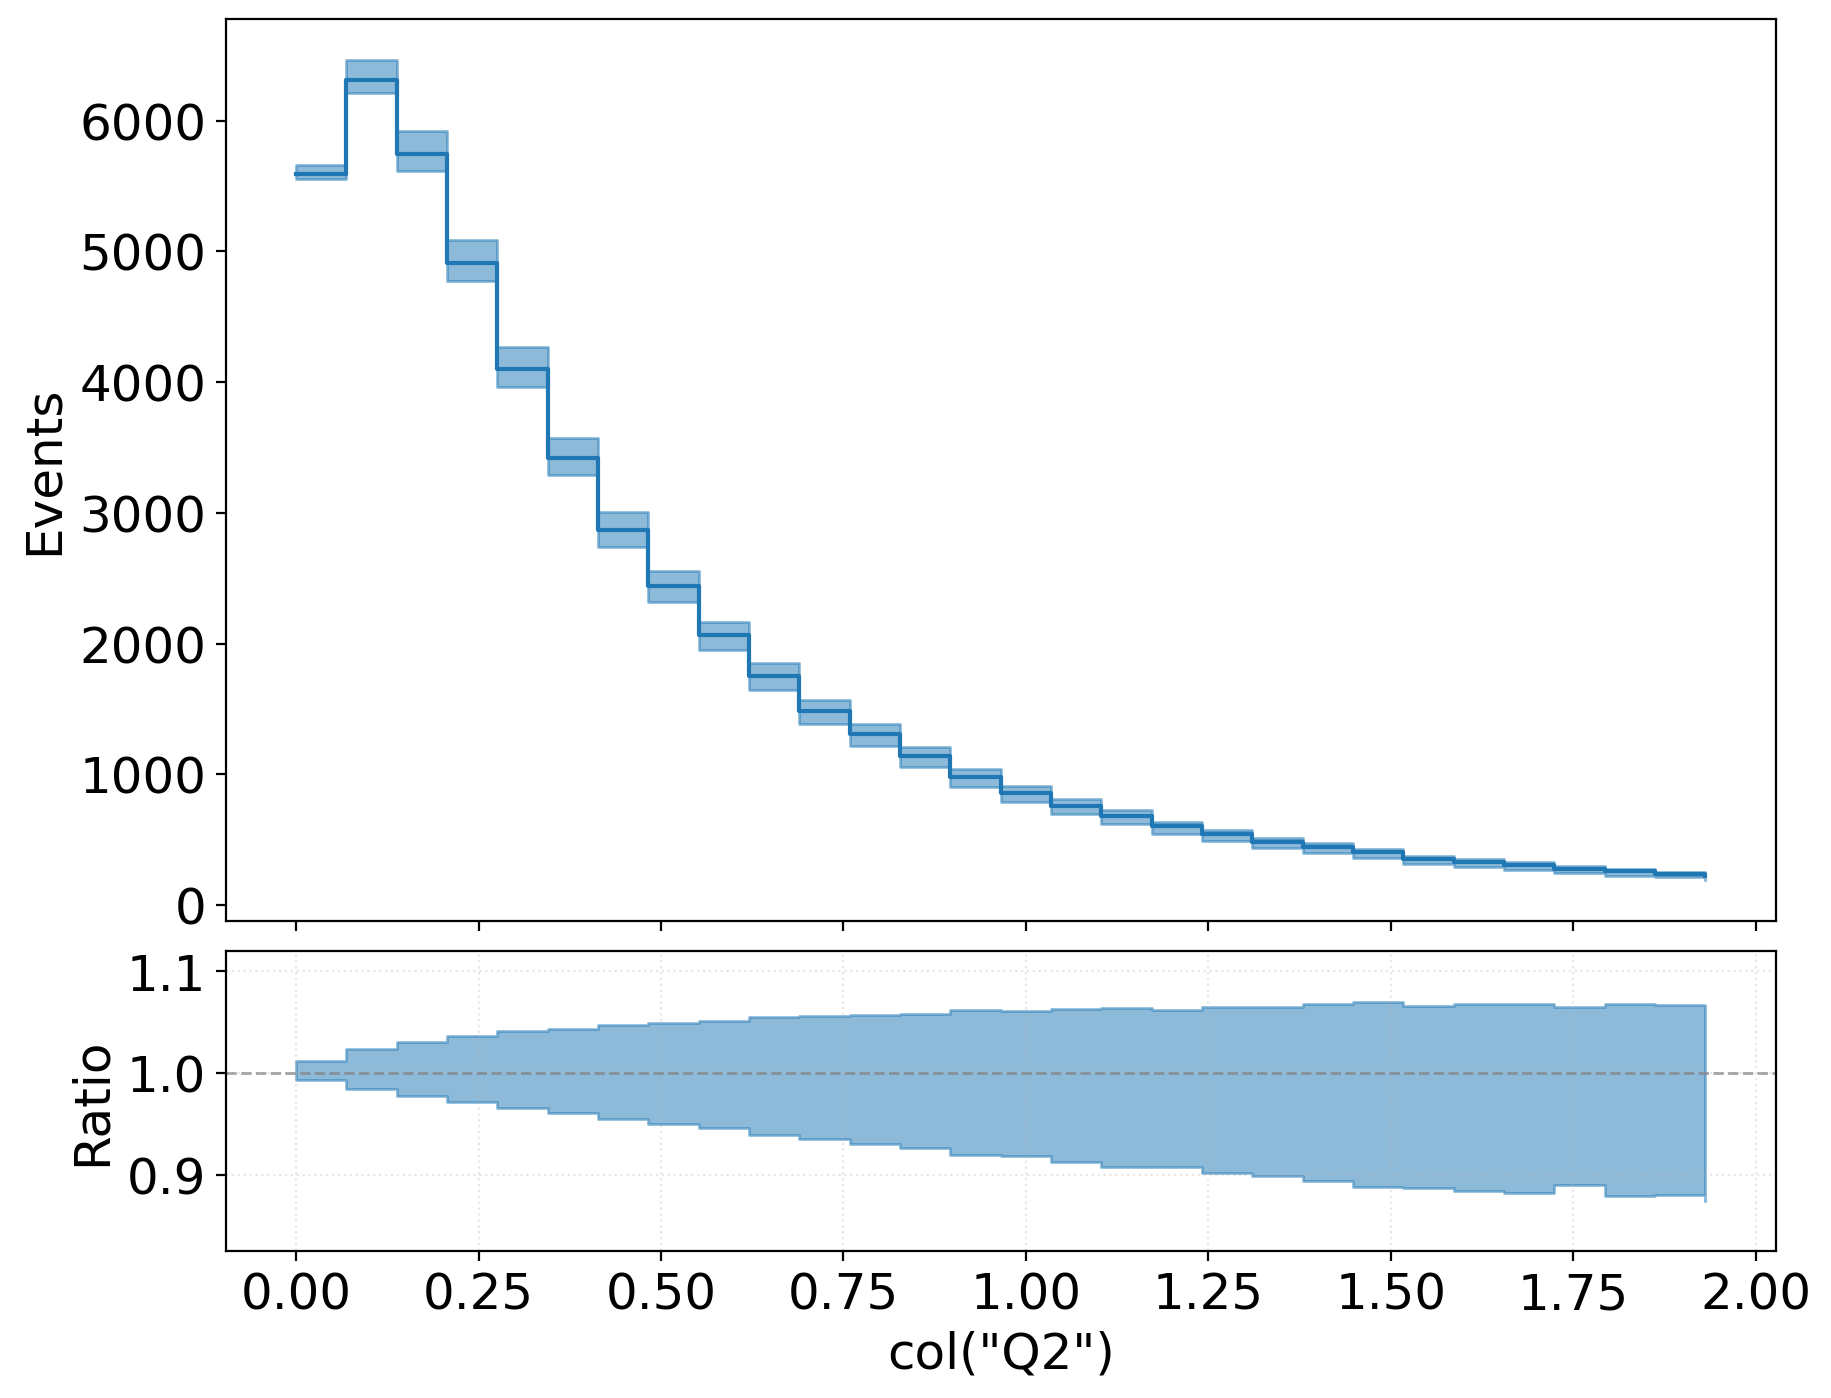

In [35]:
analyzer.plot_1sigma_band(['MaCCRES'], pl.col('Q2'), np.linspace(0, 2, 30))

In [36]:
systs_groups = {
    "CCQE": ['b1', 'b2', 'b3', 'b4', 'VecFFCCQEshape'],
    "BodekYang": ['AhtBY', 'BhtBY', 'CV1uBY', 'CV2uBY'],
    'FSI': ['FrAbs_N', 'FrAbs_pi', 'FrCEx_N', 'FrCEx_pi', 'FrInel_N', 'FrInel_pi', 'FrPiProd_N', 'FrPiProd_pi', 'MFP_N', 'MFP_pi'],
    'CCRES': ['MaRes_ResCode0', 'MaRes_ResCode1', 'MvRes_ResCode0', 'MvRes_ResCode1', 'RDecBR1eta', 'RDecBR1gamma', 'Theta_Delta2Npi'],
    'NC': ['MaNCRES', 'MvNCRES', 'MaNCEL', 'EtaNCEL'],
    'MEC': ['EnergyDependence_CCMEC', 'FracDelta_CCMEC', 'FracPN_CCMEC', 'XSecShape_CCMEC', 'XSecShape_CCMEC_Empirical', 'XSecShape_CCMEC_Martini', 'C12ToAr40_2p2hScaling_nu', 'C12ToAr40_2p2hScaling_nubar'], #DecayAngMECVariationResponse
    'CCSIS': ['NonRESBGvbarnCC1pi', 'NonRESBGvbarnCC2pi', 'NonRESBGvbarpCC1pi', 'NonRESBGvbarpCC2pi', 'NonRESBGvnCC1pi', 'NonRESBGvnCC2pi', 'NonRESBGvpCC1pi', 'NonRESBGvpCC2pi'],
    'NCSIS': ['NonRESBGvbarnNC1pi', 'NonRESBGvbarnNC2pi', 'NonRESBGvbarpNC1pi', 'NonRESBGvbarpNC2pi', 'NonRESBGvnNC1pi', 'NonRESBGvnNC2pi', 'NonRESBGvpNC1pi', 'NonRESBGvpNC2pi'],
    "Others": ['nucleus_radius', 'surface_thickness', 'nuenuebar_xsec_ratio', 'nuenumu_xsec_ratio']
}

# Producing standardized series of plots for all the dials

In [26]:
# Example: Create a 2x3 grid of plots, each with ratio panels
all_systs = systs.get_all_systs()

for syst in tqdm(all_systs):  # Test with first systematic
    local_systs = [syst]
    
    # Create figure with 4 rows (2 main + 2 ratio) and 3 columns
    fig = plt.figure(figsize=(20, 10), constrained_layout=True)
    gs = fig.add_gridspec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0)
    
    # Create axes pairs for each plot
    ax_00_main = fig.add_subplot(gs[0, 0])
    ax_00_ratio = fig.add_subplot(gs[1, 0], sharex=ax_00_main)
    
    ax_01_main = fig.add_subplot(gs[0, 1])
    ax_01_ratio = fig.add_subplot(gs[1, 1], sharex=ax_01_main)
    
    ax_02_main = fig.add_subplot(gs[0, 2])
    ax_02_ratio = fig.add_subplot(gs[1, 2], sharex=ax_02_main)
    
    ax_10_main = fig.add_subplot(gs[2, 0])
    ax_10_ratio = fig.add_subplot(gs[3, 0], sharex=ax_10_main)
    
    ax_11_main = fig.add_subplot(gs[2, 1])
    ax_11_ratio = fig.add_subplot(gs[3, 1], sharex=ax_11_main)
    
    ax_12_main = fig.add_subplot(gs[2, 2])
    ax_12_ratio = fig.add_subplot(gs[3, 2], sharex=ax_12_main)
    
    # Plot 1: True Energy
    fig_en = MultiPlot(analyzer, bin_var=pl.col('Ev'), bins=np.logspace(-1, 1, 50), ax=(ax_00_main, ax_00_ratio))
    fig_en.add_syst_band(local_systs, r'Reco $\nu_e$', nue_filter)
    fig_en.add_syst_band(local_systs, r'Reco $\nu_\mu$', numu_filter)
    fig_en.legend()
    ax_00_main.set_xscale('log')
    ax_00_ratio.set_xlabel('True Energy (GeV)')
    
    # Plot 2: Reconstructed Hadronic Energy
    fig_en = MultiPlot(analyzer, bin_var=pl.col('reco_Ehad'), bins=np.logspace(-1, 1, 50), ax=(ax_01_main, ax_01_ratio))
    fig_en.add_syst_band(local_systs, r'Reco $\nu_e$', nue_filter)
    fig_en.add_syst_band(local_systs, r'Reco $\nu_\mu$', numu_filter)
    fig_en.legend()
    ax_01_main.set_xscale('log')
    ax_01_ratio.set_xlabel('Reconstructed Hadronic Energy (GeV)')
    
    # Plot 3: Reconstructed Leptonic Energy
    fig_en = MultiPlot(analyzer, bin_var=pl.col('reco_Elep'), bins=np.logspace(-1, 1, 50), ax=(ax_02_main, ax_02_ratio))
    fig_en.add_syst_band(local_systs, r'Reco $\nu_e$', nue_filter)
    fig_en.add_syst_band(local_systs, r'Reco $\nu_\mu$', numu_filter)
    fig_en.legend()
    ax_02_main.set_xscale('log')
    ax_02_ratio.set_xlabel('Reconstructed Leptonic Energy (GeV)')
    
    # Plot 4: Reconstructed Total Energy
    fig_dir = MultiPlot(analyzer, bin_var=pl.col('reco_E'), bins=np.logspace(-1, 1, 50), ax=(ax_10_main, ax_10_ratio))
    fig_dir.add_syst_band(local_systs, r'Reco $\nu_e$', nue_filter)
    fig_dir.add_syst_band(local_systs, r'Reco $\nu_\mu$', numu_filter)
    fig_dir.legend()
    ax_10_main.set_xscale('log')
    ax_10_ratio.set_xlabel(r'Reconstructed energy (GeV)')
    
    # Plot 5: Reconstructed Direction
    fig_dir = MultiPlot(analyzer, bin_var=pl.col('reco_direc'), bins=np.linspace(-1, 1, 50), ax=(ax_11_main, ax_11_ratio))
    fig_dir.add_syst_band(local_systs, r'Reco $\nu_e$', nue_filter)
    fig_dir.add_syst_band(local_systs, r'Reco $\nu_\mu$', numu_filter)
    fig_dir.legend()
    ax_11_ratio.set_xlabel(r'Reconstructed $\cos\theta_y$')
    
    # Plot 6: True Direction
    fig_dir = MultiPlot(analyzer, bin_var=pl.col('direc_true'), bins=np.linspace(-1, 1, 50), ax=(ax_12_main, ax_12_ratio))
    fig_dir.add_syst_band(local_systs, r'Reco $\nu_e$', nue_filter)
    fig_dir.add_syst_band(local_systs, r'Reco $\nu_\mu$', numu_filter)
    fig_dir.legend()
    ax_12_ratio.set_xlabel(r'True $\cos\theta_y$')
    
    fig.suptitle(f'Systematic: {syst.name}', fontsize=16)
    fig.savefig(f'systematic_plots/{syst.name}_syst_band.png', bbox_inches='tight')
    fig.savefig(f'systematic_plots/{syst.name}_syst_band.pdf', bbox_inches='tight')
    plt.close(fig)
    # break  # Remove this to process all systematics

 56%|█████▌    | 38/68 [01:48<01:28,  2.96s/it]

No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi
No reference index (0) found in paramVariations for syst Theta_Delta2Npi


 57%|█████▋    | 39/68 [01:51<01:23,  2.89s/it]

No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape
No reference index (0) found in paramVariations for syst VecFFCCQEshape


 65%|██████▍   | 44/68 [02:05<01:09,  2.90s/it]

No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC
No reference index (0) found in paramVariations for syst DecayAng2MEC


 68%|██████▊   | 46/68 [02:10<01:00,  2.77s/it]

 69%|██████▉   | 47/68 [02:13<00:57,  2.72s/it]

 71%|███████   | 48/68 [02:16<00:53,  2.69s/it]

No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC
No reference index (0) found in paramVariations for syst FracDelta_CCMEC


 72%|███████▏  | 49/68 [02:18<00:50,  2.66s/it]

No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC
No reference index (0) found in paramVariations for syst FracPN_CCMEC


 74%|███████▎  | 50/68 [02:21<00:47,  2.66s/it]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1496: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


 75%|███████▌  | 51/68 [02:23<00:44,  2.63s/it]

 76%|███████▋  | 52/68 [02:26<00:43,  2.70s/it]

 78%|███████▊  | 53/68 [02:29<00:40,  2.71s/it]

 85%|████████▌ | 58/68 [02:43<00:27,  2.79s/it]

 87%|████████▋ | 59/68 [02:46<00:25,  2.82s/it]

 88%|████████▊ | 60/68 [02:49<00:22,  2.83s/it]

 90%|████████▉ | 61/68 [02:52<00:19,  2.85s/it]

<string>:56: RuntimeWarning: invalid value encountered in divide
<string>:57: RuntimeWarning: divide by zero encountered in divide


 91%|█████████ | 62/68 [02:55<00:16,  2.82s/it]

No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0
No reference index (0) found in paramVariations for syst MaRes_ResCode0


 93%|█████████▎| 63/68 [02:58<00:14,  2.93s/it]

No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1
No reference index (0) found in paramVariations for syst MaRes_ResCode1


 94%|█████████▍| 64/68 [03:01<00:11,  2.96s/it]

No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0
No reference index (0) found in paramVariations for syst MvRes_ResCode0


 96%|█████████▌| 65/68 [03:04<00:09,  3.01s/it]

No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1
No reference index (0) found in paramVariations for syst MvRes_ResCode1


 97%|█████████▋| 66/68 [03:07<00:06,  3.02s/it]

No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius
No reference index (0) found in paramVariations for syst nucleus_radius


 99%|█████████▊| 67/68 [03:12<00:03,  3.49s/it]

No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness
No reference index (0) found in paramVariations for syst surface_thickness


100%|██████████| 68/68 [03:15<00:00,  2.88s/it]


# Old things

In [38]:
# plt.hist(genie['Ecalo'], bins=Ebins, histtype='step');

def plot_1sigma_band_2d(syst_names, mask=True, bin_var_x='reco_E', bin_var_y='reco_direc', bins_x=np.logspace(-1, 1, 50), bins_y=np.linspace(-1, 1, 50)):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sigma_up, sigma_down = None, None

    filtered_data = data.filter(mask)

    for syst_name in syst_names:
        syst = systs_header.filter(pl.col('name') == syst_name).row(0, named=True)
        variations = read_syst('./systs_new_cafs.root', syst).filter(filter_mask).filter(mask)
        ref, xedges, yedges = np.histogram2d(filtered_data[bin_var_x], filtered_data[bin_var_y], bins=[bins_x, bins_y], weights=variations[f'{syst["name"]}_3']*filtered_data['final_oscillated_w'])
        up_1sigma = np.histogram2d(filtered_data[bin_var_x], filtered_data[bin_var_y], bins=[bins_x, bins_y], weights=variations[f'{syst["name"]}_4']*filtered_data['final_oscillated_w'])
        down_1sigma = np.histogram2d(filtered_data[bin_var_x], filtered_data[bin_var_y], bins=[bins_x, bins_y], weights=variations[f'{syst["name"]}_2']*filtered_data['final_oscillated_w'])

        pos_1sigma = np.maximum(np.maximum(ref - up_1sigma[0], ref - down_1sigma[0]), 0)
        neg_1sigma = np.minimum(np.minimum(ref - up_1sigma[0], ref - down_1sigma[0]), 0)
        if sigma_up is None:
            sigma_up = pos_1sigma**2
            sigma_down = neg_1sigma**2
        else:
            sigma_up = sigma_up + pos_1sigma**2
            sigma_down = sigma_down + neg_1sigma**2

    # Plotting code for 2D histograms
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
    axs[0].pcolormesh(X, Y, 1+(sigma_up**0.5/ref), shading='auto', cmap='jet')
    # fig.colorbar(label='1 Sigma Up / Nominal', ax=axs[0])
    axs[0].set_xlabel(bin_var_x)
    axs[0].set_ylabel(bin_var_y)
    axs[0].set_title('1 Sigma Up Variation')
    axs[0].set_xscale('log')
    axs[1].pcolormesh(X, Y, 1-(sigma_down**0.5/ref), shading='auto', cmap='jet')
    # fig.colorbar(label='1 Sigma Down / Nominal', ax=axs[1])
    axs[1].set_xlabel(bin_var_x)
    axs[1].set_ylabel(bin_var_y)
    axs[1].set_title('1 Sigma Down Variation')
    axs[1].set_xscale('log')

    # fig.colorbar(label='Variation / Nominal', ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
    plt.tight_layout()

def plot_2d(systematic, systs_config, mask=True, bin_var_x='reco_E', bin_var_y='reco_direc', bins_x=np.logspace(-1, 1, 50), bins_y=np.linspace(-1, 1, 50)):
    fig, ax = plt.subplots(figsize=(8, 6))

    filtered_data = data.filter(mask)

    if type(systematic) is str:
        syst = systs_header.filter(pl.col('name') == systematic).row(0, named=True)
        variations = read_syst('./merged_new_systs.root', syst).filter(filter_mask).filter(mask)
    elif type(systematic) is pl.DataFrame:
        variations = systematic.filter(filter_mask).filter(mask)
        syst = {'name': variations.columns[0].rsplit('_', 1)[0]}  # Extract syst name from column name
    else:
        raise ValueError("systs must be a list of strings or DataFrames")
    
    syst_config = get_syst_from_config(systs_config, syst['name'])
    if 'paramVariations' not in syst_config:
        print(f"Warning: 'paramVariations' not found in syst config for syst {syst['name']}, skipping.")
        return
    if 0 in syst_config['paramVariations']:
        ref_idx = syst_config['paramVariations'].index(0)
    else:
        raise ValueError(f"No reference index (0) found in paramVariations for syst {syst['name']}")
    if 1 in syst_config['paramVariations']:
        p1s_idx = syst_config['paramVariations'].index(1)
    else:
        p1s_idx = ref_idx
        print(f"Warning: No +1 sigma index found in paramVariations for syst {syst['name']}, using reference index instead.")
    if -1 in syst_config['paramVariations']:
        m1s_idx = syst_config['paramVariations'].index(-1)
    else:
        m1s_idx = ref_idx
        print(f"Warning: No -1 sigma index found in paramVariations for syst {syst['name']}, using reference index instead.")

    ref, xedges, yedges = np.histogram2d(filtered_data[bin_var_x], filtered_data[bin_var_y], bins=[bins_x, bins_y], weights=variations[f'{syst["name"]}_{p1s_idx}']*filtered_data['final_oscillated_w'])

    # Plotting code for 2D histograms
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
    pcm = ax.pcolormesh(X, Y, ref, shading='auto', cmap='jet')
    fig.colorbar(pcm, label='Events', ax=ax)
    ax.set_xlabel(bin_var_x)
    ax.set_ylabel(bin_var_y)
    ax.set_title('Nominal Distribution')
    ax.set_xscale('log')

    plt.tight_layout()

In [39]:
nue_mask = data['reco_pdg'] == Flavor.NuE
numu_mask = data['reco_pdg'] == Flavor.NuMu

plot_1sigma_band_2d(['b1', 'b2', 'b3', 'b4'], nue_mask, bin_var_x='reco_E', bin_var_y='reco_direc', bins_x=np.logspace(-1, 1, 50), bins_y=np.linspace(-1, 1, 20))
plt.xscale('log')

plot_1sigma_band_2d(['b1', 'b2', 'b3', 'b4'], numu_mask, bin_var_x='reco_E', bin_var_y='reco_direc', bins_x=np.logspace(-1, 1, 50), bins_y=np.linspace(-1, 1, 20))
# plot_1sigma_band_2d(['b1', 'b2', 'b3', 'b4'], numu_mask, bin_var_x='Ev', bin_var_y='direc_true', bins_x=np.logspace(-1, 1, 100), bins_y=np.linspace(-1, 1, 100))
plt.xscale('log')

NameError: name 'data' is not defined

In [40]:
plot_2d('b1', systs_config, mask=nue_mask, bin_var_x='q0', bin_var_y='q3', bins_x=np.linspace(0, 1, 100), bins_y=np.linspace(0, 1, 100))
plt.xscale('linear')

NameError: name 'systs_config' is not defined

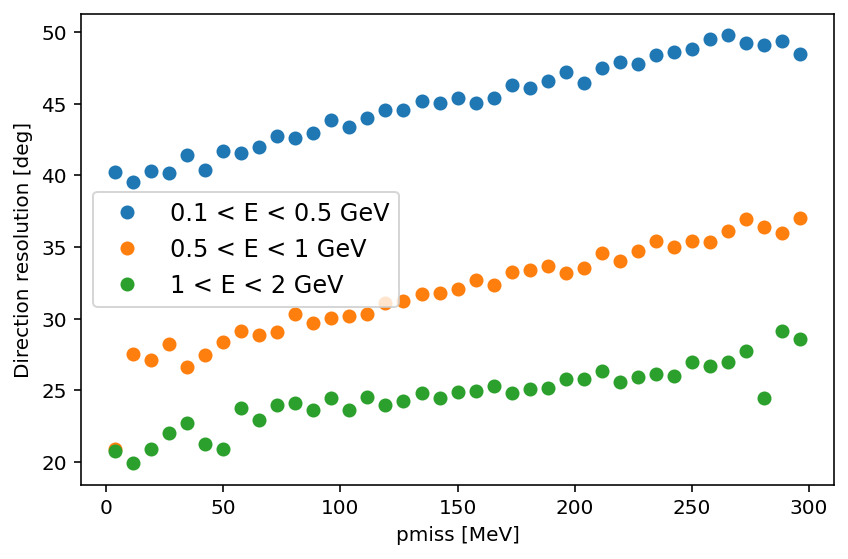

In [6]:
#Plotting the direction reco as a function of energy
# Ebins = np.linspace(0, 2, 40)
Pbins = np.linspace(0, 300, 40)
Ecenters = (Pbins[1:] + Pbins[:-1])/2
for Erange in ([0.1, 0.5], [0.5, 1], [1, 2]):
    selected = numu_ccqe.filter(
        pl.col('nu_E') > Erange[0],
        pl.col('nu_E') < Erange[1]
    )
    std = binned_statistic(selected['pmiss'], selected['direc_res'], statistic='std', bins=Pbins).statistic
    plt.errorbar(Ecenters, std, fmt='o', label=f'{Erange[0]} < E < {Erange[1]} GeV')
plt.xlabel('pmiss [MeV]')
plt.ylabel('Direction resolution [deg]')
plt.legend(fontsize=12)
plt.tight_layout()